In [1]:
import subprocess, re, json
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
story_list = ['story1', 'doorbell', 'Example_Story', 'Forgetfulness_Case', 
              'House_Adventure', 'lightson', 'Nighttime_Snack', 'Unpleasant_Surprise']
saved_lines = []
path = ''
with open ('config.pl', 'r') as f:
    for line in f:
        if line.startswith('domain'):
            line = re.sub('domains/(.*)\.pl', 'domains/'+story_list[1]+'.pl', line)
            path = re.match(r'domain\(\'(.*)\'\)', line).group(1)
        saved_lines.append(line.rstrip('\n'))
f.close()

story_text = []
narrative_list = []
with open(path, 'r') as f:
    for line in f:
        story_text.append(line.rstrip('\n'))
        if line.startswith('s('):
            narrative = re.search(r's\(\d\) :: (.*) at', line).group(1)
            narrative_list.append(narrative)
f.close()

with open('config.pl', 'w') as f:
    for line in saved_lines:
        f.write(line + '\n')
f.close()

In [3]:
with open ('/Users/yubinge/Documents/Human-AI/web/co_reasoning/static/tree_data/' + 's(0).json'
              , 'w') as f:
    json.dump(narrative_list, f)
f.close()

In [4]:
cmd = 'swipl -s engine.pl -g start -t halt'
cmd = cmd.split(' ')
result = subprocess.run(cmd, stdout=subprocess.PIPE)

In [5]:
text = []
qa = {}
lines = result.stdout.decode("utf-8").split('\n')
for i in range(len(lines)):
    if 'Answering question' in lines[i]:
        question = lines[i].split('Answering question ')[1].rstrip(':')
        match_answer = re.match(r'([-\?\+]) \w+ choice: ,\[(.*)at (.*)\]', lines[i + 1])
        if question not in qa:
            qa[question] = {'answer': match_answer.group(1), 'conclusion': match_answer.group(2), 'timestep': match_answer.group(3)}
        else:
            qa[question]['answer'] = match_answer.group(1)
    elif 'Acceptable argument' in lines[i] and lines[i + 1] != '':
        for j in range(i + 1, len(lines)):
            if ('-f->' in lines[j]) and 'per(p(' not in lines[j] and 'per(c(' not in lines[j] and 'per(o(' not in lines[j]:
                text.append(lines[j])
            if 'Comprehension model' in lines[j + 1]:
                break

In [6]:
for question in qa:
    if qa[question]['answer'] == '+':
        qa[question]['conclusion'] += '=true'
    elif qa[question]['answer'] == '-':
        qa[question]['conclusion'] += '#true'

In [7]:
acceptable_arguments = {}
for j in range(len(text)):
    match_result = re.match(r'(.*) : (.*) @ (\d*) -(.)-> \((.*)\)', text[j])
    argument_id = match_result.group(1)
    argument = match_result.group(2)
    
    if argument.startswith('cau'):
        argument = re.match(r'cau\((.*),\[(.*)\]\)',argument)
    elif argument.startswith('pro'):
        argument = re.match(r'pro\((.*),\[(.*)\]\)',argument)
#     else:
#         print('Wrong start with the argument' + argument)
    argument = argument.group(2) + ','
    argument_list = [s + 'true' for s in argument.split('true,')]
    
    timestep = match_result.group(3)
    conclusion = match_result.group(5)
    conclusion = re.match(r'(.*),(\d*),(.*)', conclusion).group(1)
    if argument_id not in acceptable_arguments:
        acceptable_arguments[argument_id] = {}
        acceptable_arguments[argument_id]['argument'] = argument_list[:len(argument_list)-1]
        acceptable_arguments[argument_id]['timestep'] = timestep
        acceptable_arguments[argument_id]['conclusion'] = conclusion
    elif timestep < acceptable_arguments[argument_id]['timestep']:
        acceptable_arguments[argument_id]['timestep'] = timestep

In [44]:
with open ('acceptable_arguments.json', 'w') as f:
    json.dump(acceptable_arguments, f, indent=4)
f.close()

In [45]:
with open ('qa.json', 'w') as f:
    json.dump(qa, f, indent=4)
f.close()

In [4]:
with open('acceptable_arguments.json', 'r') as f:
    acceptable_arguments = json.load(f)
f.close()

with open('qa.json', 'r') as f:
    qa = json.load(f)
f.close()

In [5]:
def find_path(start_conclusion_list, time):
    for index in range(len(start_conclusion_list)):
        start_conclusion = start_conclusion_list[index]
        for ar in acceptable_arguments:
            if start_conclusion == acceptable_arguments[ar]['conclusion']:
                con = acceptable_arguments[ar]
#                 if time < con['timestep']:
#                     print(con)
#                     for i in range(index):
#                         node1 = start_conclusion_list[i]
#                         for node2 in DG.predecessors(node1):
#                             DG.remode_node(node2)
#                     return True

                if DG.has_node(con['conclusion']) == False:
                    DG.add_node(con['conclusion'])

                premise_list = []
                for i in range(len(con['argument'])):
                    premise = con['argument'][i]
                    DG.add_node(premise)
                    DG.add_edge(con['conclusion'], premise, name=ar)
                    premise_list.append(premise)
                time_error = find_path(premise_list, time)
                if time_error == True:
                    for premise in premise_list:
                        DG.remove_node(premise)
                    return True

    return False

In [6]:
def dfs(tree):
    for neighbor in DG[(tree['id'])]:
        tree['name'] = DG[(tree['id'])][neighbor]['name']
        break
    for children in tree['children']:
        if 'children' in children:
            dfs(children)

Answering q1
has(ann,doorkeys)=true {'is_a(ann,resident)=true': {'name': 'p(13)'}}
is_a(ann,resident)=true {'flatmate(mary,ann)=true': {'name': 'p(35)'}, 'in_flat(mary)=true': {'name': 'p(35)'}}
flatmate(mary,ann)=true {}
in_flat(mary)=true {}


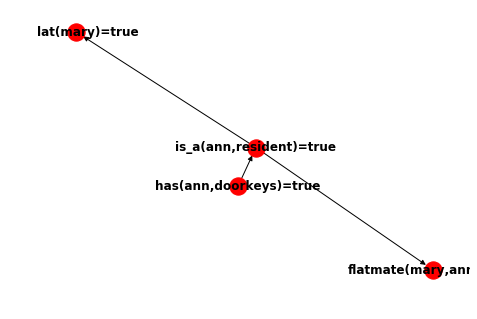

In [11]:
for i in range(0,len(qa)):
    DG = nx.DiGraph()
    start_con = qa['q(' + str(i+1) + ')']['conclusion']
    time = qa['q(' + str(i+1) + ')']['timestep']
    print('Answering q' + str(i+1))
    find_path([start_con], time)
    for n, nbrs in DG.adj.items():
        print(n, nbrs)
    nx.draw(DG, with_labels=True, font_weight='bold')
    network_data = nx.readwrite.json_graph.node_link_data(DG)

    nodes = []
    for node in network_data['nodes']:
        nodes.append(node['id'])
    for link in network_data['links']:
        link["source"] = nodes.index(link["source"])
        link["target"] = nodes.index(link["target"])
        tmp = link["source"]
        link["source"] = link["target"]
        link["target"] = tmp
#     print(network_data)
#     dfs(network_data)
    with open ('/Users/yubinge/Documents/Human-AI/web/co_reasoning/static/data/' + 'q(' + str(i+1) + ').json'
              , 'w') as f:
        json.dump(network_data, f, indent=4)
    f.close()
#     print(network_data)
    break

## Add/Modification/Delete

In [32]:
# Add a node named 'ABC' for p(4)
change_rule = 'p(35)'
acceptable_arguments[change_rule]['argument'].append('ABC#true')
# Write to file

In [33]:
for line in story_text:
    if line.startswith(change_rule + ' ::'):
#         replaced_text = ':: '
        replaced_text = r'\1'
        rule = acceptable_arguments[change_rule]
        print(rule)
        length = len(rule['argument'])
        for i in range(length):
            argument = rule['argument'][i]
            if argument.endswith('=true'):
                replaced_text += argument.replace('=true',r'')
            elif argument.endswith('#true'):
                replaced_text += r'-' + argument.replace('#true',r'')
            if i < length - 1:
                replaced_text += r','
        replaced_text += r'\2 '
        if rule['conclusion'].endswith('=true'):
            replaced_text += rule['conclusion'].replace('=true',r'.')
        elif rule['conclusion'].endswith('#true'):
            replaced_text += r'-' + rule['conclusion'].replace('#true',r'.')
        line = re.sub('(:: ).*( implies| causes).*', replaced_text, line)
        print(line)
    

{'argument': ['flatmate(mary,ann)=true', 'in_flat(mary)=true', 'ABC#true'], 'timestep': '0', 'conclusion': 'is_a(ann,resident)=true'}
p(35) :: flatmate(mary,ann),in_flat(mary),-ABC implies is_a(ann,resident).


## Add an Edge

In [14]:
qa

{'q(1)': {'answer': '+',
  'conclusion': 'wants(francis,ease(sick,pie))=true',
  'timestep': '1'}}